# 1. Install and Import Packages 

In [ ]:
# Install required packages

#pip install plotnine
#pip install kmodes
#conda install lightgbm 
#pip install shap

In [ ]:
# Import module for data manipulation
import pandas as pd
#Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
import matplotlib
import pylab as plot

from decimal import Decimal

# for 2D visualisation using SHAP
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import shap

# for 3D visualisation
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(88) #will be doing random sampling later

# 2. Load Data

In [ ]:
# Load the data 
df = pd.read_csv(r"/Users/leeminli/OneDrive - National University of Singapore/MIN LI NUS/Y3S1/DSA3101/Assignment 1 Project/FINAL DATASET/hotels_booking_reviews.csv")

# The dimension of data
print('Dimension data: {} rows and {} columns'.format(len(df), len(df.columns)))

# Declare quarter as categorical variable
df['quarter'] = df['quarter'].astype('object') 

# Print the first 5 rows
df.head()

Dimension data: 1980 rows and 17 columns


,review_title,review_date,reviewer,hotel_name,hotel_avg_rating,nationality,rating,review_text,raw_review_text,quarter,hotel_type,nights_stayed,room_type,traveller_type,price_per_night,total_spending,booking_freq
0,Exceptional,2020-03-14,Vivian,Marivaux Hotel,8.500,Singapore,10.000,Staff ap friendly and Helpful. Thank you,"<p class=""review_pos ""><svg aria-label=""Positi...",1,Hotel,2,Standard Double or Twin Room,Couple,99,198,1.000
1,Very good,2020-03-12,Duncan,Marivaux Hotel,8.500,United Kingdom,8.000,Windows opened onto a deep light-well so littl...,"<p class=""review_neg ""><svg aria-label=""Negati...",1,Hotel,2,Standard Double or Twin Room,Solo traveller,99,198,1.000
2,Typical Conference Hotel close to Brussels Noo...,2020-03-11,Simon,Marivaux Hotel,8.500,Germany,8.000,breakfast did not provide a lot of selection a...,"<p class=""review_neg ""><svg aria-label=""Negati...",1,Hotel,1,Standard Single Room,Solo traveller,84,84,1.000
3,Close to metro station,2020-03-11,Gergő,Marivaux Hotel,8.500,Hungary,9.000,"none,\n\nRoom, location, breakfast - everythin...","<p class=""review_neg ""><svg aria-label=""Negati...",1,Hotel,1,Deluxe Double Room,Solo traveller,119,119,1.000
4,Fabulous,2020-03-09,Oleg,Marivaux Hotel,8.500,Germany,8.800,"Unique style, and secret parking made my day","<p class=""review_pos ""><svg aria-label=""Positi...",1,Hotel,1,Standard Double or Twin Room,People with friends,99,99,1.000


In [ ]:
# To append reviews back to clusters at the end

df2 = df[['review_text', 'raw_review_text']]
df2.head()

,review_text,raw_review_text
0,Staff ap friendly and Helpful. Thank you,"<p class=""review_pos ""><svg aria-label=""Positi..."
1,Windows opened onto a deep light-well so littl...,"<p class=""review_neg ""><svg aria-label=""Negati..."
2,breakfast did not provide a lot of selection a...,"<p class=""review_neg ""><svg aria-label=""Negati..."
3,"none,\n\nRoom, location, breakfast - everythin...","<p class=""review_neg ""><svg aria-label=""Negati..."
4,"Unique style, and secret parking made my day","<p class=""review_pos ""><svg aria-label=""Positi..."


In [ ]:
# For EDA

df3 = df[['hotel_name']]
df3.head()

,hotel_name
0,Marivaux Hotel
1,Marivaux Hotel
2,Marivaux Hotel
3,Marivaux Hotel
4,Marivaux Hotel


### 2.1. Variables Used For Clustering

In [ ]:
# We will be using 4 variables to cluster the customers
# Extract these 4 columns

df = df[['rating','quarter', 'traveller_type', 'price_per_night']] 
df.head()


,rating,quarter,traveller_type,price_per_night
0,10.000,1,Couple,99
1,8.000,1,Solo traveller,99
2,8.000,1,Solo traveller,84
3,9.000,1,Solo traveller,119
4,8.800,1,People with friends,99


### 2.2. Get Types of Traveller

In [ ]:
# Get the types of travellers

unique_trav_types = df.traveller_type.value_counts()
print(unique_trav_types)

#data is unbalanced

Couple                        880
Solo traveller                435
Family with young children    381
Group                         201
People with friends            83
Name: traveller_type, dtype: int64


### 2.3. Recategorise the Types of Travellers

In [ ]:
# 'Recategorise 'People with friends' and 'Family with young children' as 'Group'

df['traveller_type'] = df['traveller_type'].str.replace('People with friends','Group')
df['traveller_type'] = df['traveller_type'].str.replace('Family with young children','Group')

In [ ]:
# Get the types of travellers after recategorising

unique_trav_types = df.traveller_type.value_counts()
print(unique_trav_types)
# Dataset is more balanced than before

Couple            880
Group             665
Solo traveller    435
Name: traveller_type, dtype: int64


### 2.4. Get Balanced Dataset
#### By retreiving 400 random samples from each type of traveller

In [ ]:
# Random sample 400 from each traveller_type to get a balanced sample

couple_df = df.loc[df['traveller_type'] == 'Couple'] # Extract rows with traveller_type = 'Couple'
couple_df.describe() #check no. of rows of 'Couples'
sample_400_couple_df = couple_df.sample(n=400) #random sample of 400 rows of couples
sample_400_couple_df.describe() #check no. of rows is 400


solo_df = df.loc[df['traveller_type'] == 'Solo traveller']
solo_df.describe() #check no. of rows of 'Solo traveller'
sample_400_solo_df = solo_df.sample(n=400) #random sample of 400 rows of Solo travellers
sample_400_solo_df.describe() #check no. of rows is 400


group_df = df.loc[df['traveller_type'] == 'Group']
group_df.describe() #check no. of rows of 'Group'
sample_400_group_df = group_df.sample(n=400) #random sample of 400 rows of group travellers
sample_400_group_df.describe() #check no. of rows is 400

,rating,price_per_night
count,400.000,400.000
mean,8.607,162.102
std,1.650,59.515
min,1.000,99.000
25%,7.975,115.000
50%,9.000,144.000
75%,10.000,200.000
max,10.000,384.000


In [ ]:
# Combine sampled dataset together
# This df will be the one used for clustering

df_sampled = pd.concat([sample_400_solo_df, sample_400_couple_df, sample_400_group_df], axis=0) #combine samples
original_df = df_sampled.copy()
df_sampled.head()

,rating,quarter,traveller_type,price_per_night
3,9.000,1,Solo traveller,119
340,10.000,1,Solo traveller,145
1615,10.000,2,Solo traveller,190
1222,1.000,1,Solo traveller,158
102,8.300,2,Solo traveller,99


# 3. EDA

In [ ]:
# categorical vars

df_sampled.select_dtypes('object').nunique()

quarter           4
traveller_type    3
dtype: int64

In [ ]:
# Inspect the numerical variables

df_sampled.describe()

,rating,price_per_night
count,1200.000,1200.000
mean,8.672,152.651
std,1.511,55.180
min,1.000,84.000
25%,8.000,108.000
50%,9.000,143.000
75%,10.000,170.000
max,10.000,517.000


In [ ]:
# Get correlation matrix for numerical variables (price_per_night and rating)

df_sampled.corr()

,rating,price_per_night
rating,1.000,0.179
price_per_night,0.179,1.000


In [ ]:
# Get the position of categorical columns

catColumnsPos = [df_sampled.columns.get_loc(col) for col in list(df_sampled.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df_sampled.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos)) 

Categorical columns           : ['quarter', 'traveller_type']
Categorical columns position  : [1, 2]


In [ ]:
# Convert dataframe to matrix

dfMatrix = df_sampled.to_numpy()
dfMatrix

array([[9.0, 1, 'Solo traveller', 119],
       [10.0, 1, 'Solo traveller', 145],
       [10.0, 2, 'Solo traveller', 190],
       ...,
       [9.6, 2, 'Group', 143],
       [9.2, 1, 'Group', 240],
       [10.0, 1, 'Group', 108]], dtype=object)

# 4. Implementing Model
### 4.1 Choosing optimal number of clusters using Elbow method

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


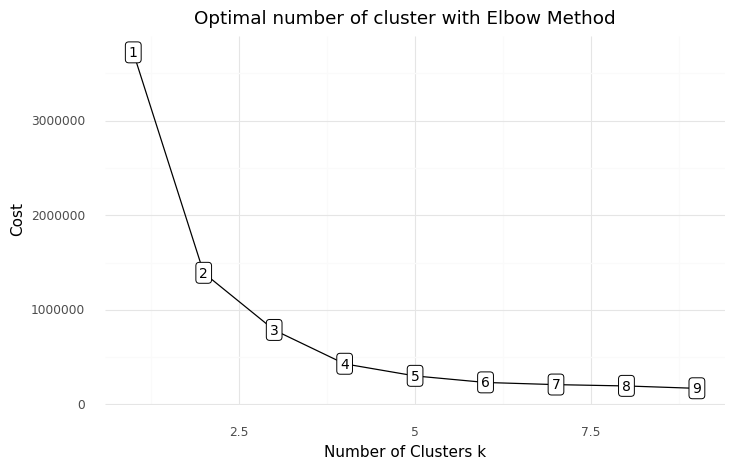

<ggplot: (8784026024015)>

In [ ]:
# Choose optimal K using Elbow method

cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})
# # Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

### 4.2. Implementing K-Prototype Model for 3 Clusters

In [ ]:
# Fit the cluster

kprototype_3 = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
clusters_3 = kprototype_3.fit_predict(dfMatrix, categorical = catColumnsPos)

In [ ]:
# Cluster centorid
kprototype_3.cluster_centroids_

# Check the iteration of the clusters created
kprototype_3.n_iter_

# Check the cost of the clusters created
kprototype_3.cost_

787037.9341725851

In [ ]:
# Add the cluster to the dataframe
df_sampled_3 = df_sampled.copy()
df_sampled_3['Cluster Labels'] = kprototype_3.labels_

# Cluster Label column  as type = category
df_sampled_3['Cluster Labels'] = df_sampled_3['Cluster Labels'].astype('category')
df_sampled_3.head()

,rating,quarter,traveller_type,price_per_night,Cluster Labels
3,9.000,1,Solo traveller,119,2
340,10.000,1,Solo traveller,145,2
1615,10.000,2,Solo traveller,190,1
1222,1.000,1,Solo traveller,158,1
102,8.300,2,Solo traveller,99,2


### 4.3. Cluster Interpretation for 3 Clusters

In [ ]:
# Cluster interpretation

df_sampled_3['Cluster'] = df_sampled_3['Cluster Labels']
df_sampled_3.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_sampled_3.groupby('Cluster').agg(
    {
        'Total':'count',
        'traveller_type': lambda x: x.value_counts().index[0],
        'quarter': lambda x: x.value_counts().index[0],
        'price_per_night': 'mean',
        'rating': 'mean'
    }
).reset_index()

,Cluster,Total,traveller_type,quarter,price_per_night,rating
0,0,102,Group,4,283.667,9.296
1,1,382,Group,1,182.144,8.790
2,2,716,Solo traveller,4,118.251,8.521


### 4.4. Calculate Silhouette Score of K-Prototype Model for 3 Clusters

In [ ]:
# Calculate Silhouette Score of Model

_identical_cluster_labels = list(dict.fromkeys(df_sampled_3['Cluster']))

def calc_euclian_dis(_s1, _s2):
    # s1 = np.array((3, 5))
    _eucl_dist = np.linalg.norm(_s2 - _s1)  # calculate Euclidean distance, accept input an array [2 6]
    return _eucl_dist
def calc_simpleMatching_dis(_s1, _s2):
    _cat_dist = 0
    if (_s1 != _s2):
        _cat_dist = 1
    return _cat_dist
k = 3
# ------------- calculate _silhouette_Index -------------
# 1. Calculate ai
_silhouette_Index_arr = []
for i in df_sampled_3.itertuples():
    _ai_cluster_label = i[-1]
    #print(_ai_cluster_label)
    # return samples of the same cluster
    _samples_cluster = original_df[df_sampled_3['Cluster'] == _ai_cluster_label]
    _dist_array_ai = []
    _s1_nume_att = np.array((i[1], i[2]))
    _s1_cat_att = i[3]
    for j in _samples_cluster.itertuples():
        _s2_nume_att = np.array((j[1], j[2]))
        _s2_cat_att = j[3]
        _euclian_dis = calc_euclian_dis(_s1_nume_att, _s2_nume_att)
        _cat_dis = calc_simpleMatching_dis(_s1_cat_att, _s2_cat_att)
        _dist_array_ai.append(_euclian_dis + (kprototype.gamma * _cat_dis))
    ai = np.average(_dist_array_ai)
    # 2. Calculate bi
    # 2.1. determine the samples of other clusters
    #print(_ai_cluster_label)
    _identical_cluster_labels.remove(_ai_cluster_label)
    _dic_cluseter = {}
    _bi_arr = []
    for ii in _identical_cluster_labels:
        _samples = original_df[df_sampled_3['Cluster'] == ii]
        # 2.2. calculate bi
        _dist_array_bi = []
        for j in _samples.itertuples():
            _s2_nume_att = np.array((j[1], j[2]))
            _s2_cat_att = j[3]
            _euclian_dis = calc_euclian_dis(_s1_nume_att, _s2_nume_att)
            _cat_dis = calc_simpleMatching_dis(_s1_cat_att, _s2_cat_att)
            _dist_array_bi.append(_euclian_dis + (kprototype.gamma * _cat_dis))
        _bi_arr.append(np.average(_dist_array_bi))
    _identical_cluster_labels.append(_ai_cluster_label)
    # min bi is determined as final bi variable
    bi = min(_bi_arr)
    # 3. calculate silhouette Index
    if ai == bi:
        _silhouette_i = 0
    elif ai < bi:
        _silhouette_i = 1 - (ai / bi)
    elif ai > bi:
        _silhouette_i = 1 - (bi / ai)
    _silhouette_Index_arr.append(_silhouette_i)
silhouette_score = np.average(_silhouette_Index_arr)
print('_silhouette_Index = ' + str(silhouette_score))


_silhouette_Index = 0.1520792725244602


### 4.5. Implementing K-Prototype Model for 4 Clusters

In [ ]:
# Fit the cluster

kprototype_4 = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
clusters_4 = kprototype_4.fit_predict(dfMatrix, categorical = catColumnsPos)

In [ ]:
# Cluster centorid
kprototype_4.cluster_centroids_

# Check the iteration of the clusters created
kprototype_4.n_iter_

# Check the cost of the clusters created
kprototype_4.cost_

429545.5789591605

In [ ]:
# Add the cluster to the dataframe
df_sampled_4 = df_sampled.copy()
df_sampled_4['Cluster Labels'] = kprototype_4.labels_

# Cluster Label column  as type = category
df_sampled_4['Cluster Labels'] = df_sampled_4['Cluster Labels'].astype('category')
df_sampled_4.head()

,rating,quarter,traveller_type,price_per_night,Cluster Labels
3,9.000,1,Solo traveller,119,1
340,10.000,1,Solo traveller,145,2
1615,10.000,2,Solo traveller,190,0
1222,1.000,1,Solo traveller,158,2
102,8.300,2,Solo traveller,99,1


### 4.6. Cluster Interpretation for 4 Clusters

In [ ]:
# Cluster interpretation

df_sampled_4['Cluster'] = df_sampled_4['Cluster Labels']
df_sampled_4.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_sampled_4.groupby('Cluster').agg(
    {
        'Total':'count',
        'traveller_type': lambda x: x.value_counts().index[0],
        'quarter': lambda x: x.value_counts().index[0],
        'price_per_night': 'mean',
        'rating': 'mean'
    }
).reset_index()

,Cluster,Total,traveller_type,quarter,price_per_night,rating
0,0,208,Group,3,211.125,8.951
1,1,435,Solo traveller,1,103.814,8.431
2,2,492,Couple,4,150.807,8.662
3,3,65,Couple,4,306.323,9.474


### 4.7. Calculate Silhouette Score of K-Prototype Model for 4 Clusters

In [ ]:
# Calculate Silhouette Score of Model

_identical_cluster_labels = list(dict.fromkeys(df_sampled_4['Cluster']))

def calc_euclian_dis(_s1, _s2):
    # s1 = np.array((3, 5))
    _eucl_dist = np.linalg.norm(_s2 - _s1)  # calculate Euclidean distance, accept input an array [2 6]
    return _eucl_dist
def calc_simpleMatching_dis(_s1, _s2):
    _cat_dist = 0
    if (_s1 != _s2):
        _cat_dist = 1
    return _cat_dist
k = 4
# ------------- calculate _silhouette_Index -------------
# 1. Calculate ai
_silhouette_Index_arr = []
for i in df_sampled_4.itertuples():
    _ai_cluster_label = i[-1]
    #print(_ai_cluster_label)
    # return samples of the same cluster
    _samples_cluster = original_df[df_sampled_4['Cluster'] == _ai_cluster_label]
    _dist_array_ai = []
    _s1_nume_att = np.array((i[1], i[2]))
    _s1_cat_att = i[3]
    for j in _samples_cluster.itertuples():
        _s2_nume_att = np.array((j[1], j[2]))
        _s2_cat_att = j[3]
        _euclian_dis = calc_euclian_dis(_s1_nume_att, _s2_nume_att)
        _cat_dis = calc_simpleMatching_dis(_s1_cat_att, _s2_cat_att)
        _dist_array_ai.append(_euclian_dis + (kprototype.gamma * _cat_dis))
    ai = np.average(_dist_array_ai)
    # 2. Calculate bi
    # 2.1. determine the samples of other clusters
    #print(_ai_cluster_label)
    _identical_cluster_labels.remove(_ai_cluster_label)
    _dic_cluseter = {}
    _bi_arr = []
    for ii in _identical_cluster_labels:
        _samples = original_df[df_sampled_4['Cluster'] == ii]
        # 2.2. calculate bi
        _dist_array_bi = []
        for j in _samples.itertuples():
            _s2_nume_att = np.array((j[1], j[2]))
            _s2_cat_att = j[3]
            _euclian_dis = calc_euclian_dis(_s1_nume_att, _s2_nume_att)
            _cat_dis = calc_simpleMatching_dis(_s1_cat_att, _s2_cat_att)
            _dist_array_bi.append(_euclian_dis + (kprototype.gamma * _cat_dis))
        _bi_arr.append(np.average(_dist_array_bi))
    _identical_cluster_labels.append(_ai_cluster_label)
    # min bi is determined as final bi variable
    bi = min(_bi_arr)
    # 3. calculate silhouette Index
    if ai == bi:
        _silhouette_i = 0
    elif ai < bi:
        _silhouette_i = 1 - (ai / bi)
    elif ai > bi:
        _silhouette_i = 1 - (bi / ai)
    _silhouette_Index_arr.append(_silhouette_i)
silhouette_score = np.average(_silhouette_Index_arr)
print('_silhouette_Index = ' + str(silhouette_score))


_silhouette_Index = 0.18921947456225274


# 5. Save Data for Sentiment Analysis

In [ ]:
# drop 'Total' column
#df_sampled = df_sampled.drop('Total', axis = 1)
#df_sampled.head()

# Join back the reviews for sentiment analysis
df_final = df_sampled_4.join(df2)
df_final.head()

# Save the output for sentiment analysis
df_final.to_csv('dataset_sentiment_analysis.csv', index=False)

# 6. 2D Visualisations

In [ ]:
# Colour mapping to clusters

Cluster_COLOR_MAP = {0 : 'red',
                   1 : 'black',
                   2 : 'blue',
                   3 : 'turquoise'}

Cluster_color = [Cluster_COLOR_MAP[cluster] for cluster in df_sampled_4['Cluster'] ]
colours =list(Cluster_COLOR_MAP.values())

### 6.1. SHAP Method
#### Ranks variables by feature importance and shows the relationship between the value of a feature and the impact on the prediction of the clusters.

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9916305726299512
[LightGBM] [Warning] Unknown parameter: colsample_by_tree


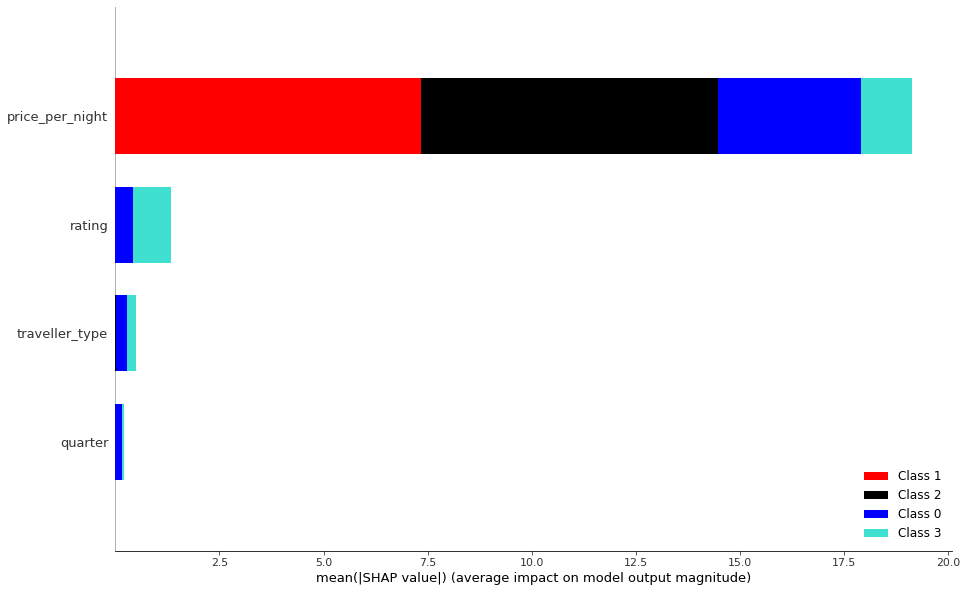

In [ ]:
# 2D Visualisation of SHAP method
# ranks variables by feature importance and shows the relationship between the value of a feature and 
# the impact on the prediction of the clusters.

# Colour mapping
CustomCmap = matplotlib.colors.ListedColormap(colours, name="MyColors")

data_corr = original_df
cat_data = data_corr.copy()
for i in cat_data.select_dtypes(include='object'):
    cat_data[i] = cat_data[i].astype('category')
proto_labs = kprototype_4.labels_
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')
clf_kp.fit(cat_data, proto_labs)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)
    
shap.summary_plot(shap_values_kp, cat_data, plot_type="bar", plot_size=(15, 10), color = CustomCmap)



# Conclusion: price_per_night variable is the most distinct variable in generating well-divided segments 
#             and contributes the most to the formation of segments. 

### 6.2. Swarmplot: 'price_per_night' Against 'Cluster'

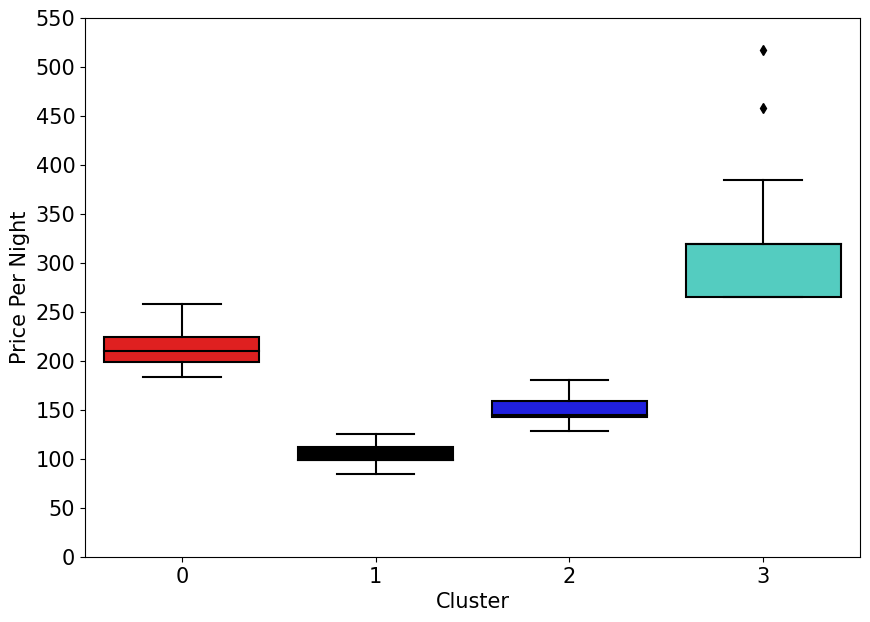

In [ ]:
# Set plotting parametres
matplotlib.rcParams.update({'font.size': 15})
fig=plt.figure(figsize=(10,7), dpi= 100, facecolor='w', edgecolor='k')
y_ticks = list(range(0,551,50))

ax = sns.boxplot(df_sampled_4.Cluster,df_sampled_4.price_per_night, palette=colours)
plt.ylabel('Price Per Night', fontsize=15)
ax.set_yticks(y_ticks)

# cluster groups are well segmented

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]

### 6.3. Swarmplot: 'rating' Against 'Cluster'

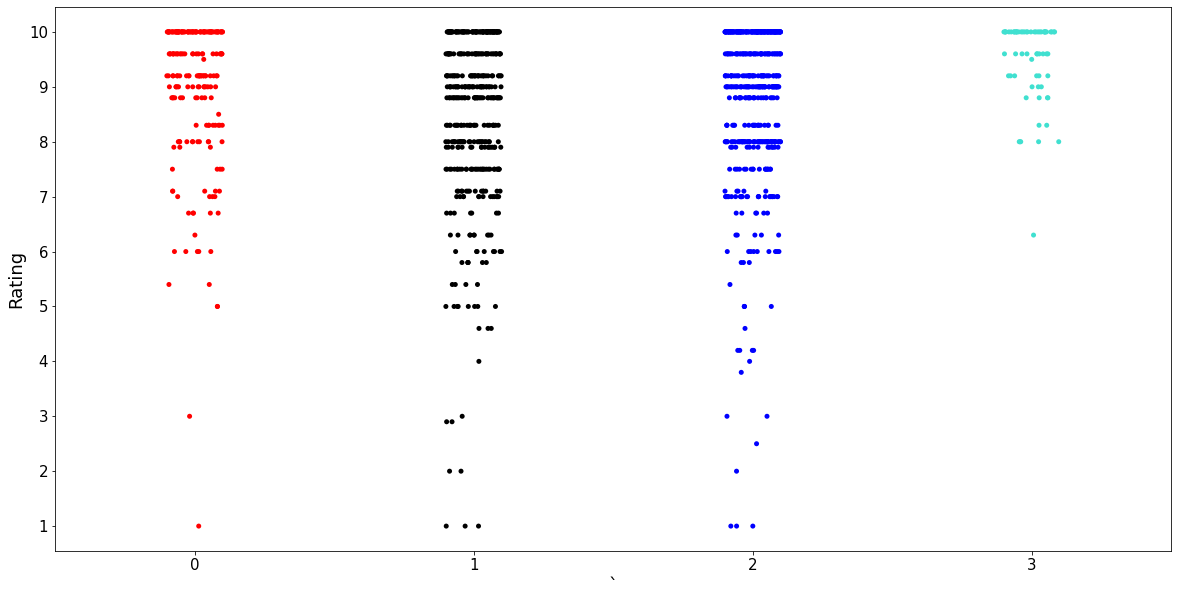

In [ ]:
# 2D Visualisation of rating against Cluster

ax2 = sns.stripplot(df_sampled_4.Cluster,df_sampled.rating,s = 5 ,alpha = 1, palette=colours)
ax2.tick_params(axis='both', which='major', labelsize=15)

l = list(range(1,11))
ax2.set_yticks(l)
plt.xlabel('`', fontsize=18)
plt.ylabel('Rating', fontsize=18)
plt.gcf().set_size_inches(20,10)

# ratings were high for Cluster 3

### 6.4. Proportion of Types of Travellors in Each Cluster

<Figure size 432x288 with 0 Axes>

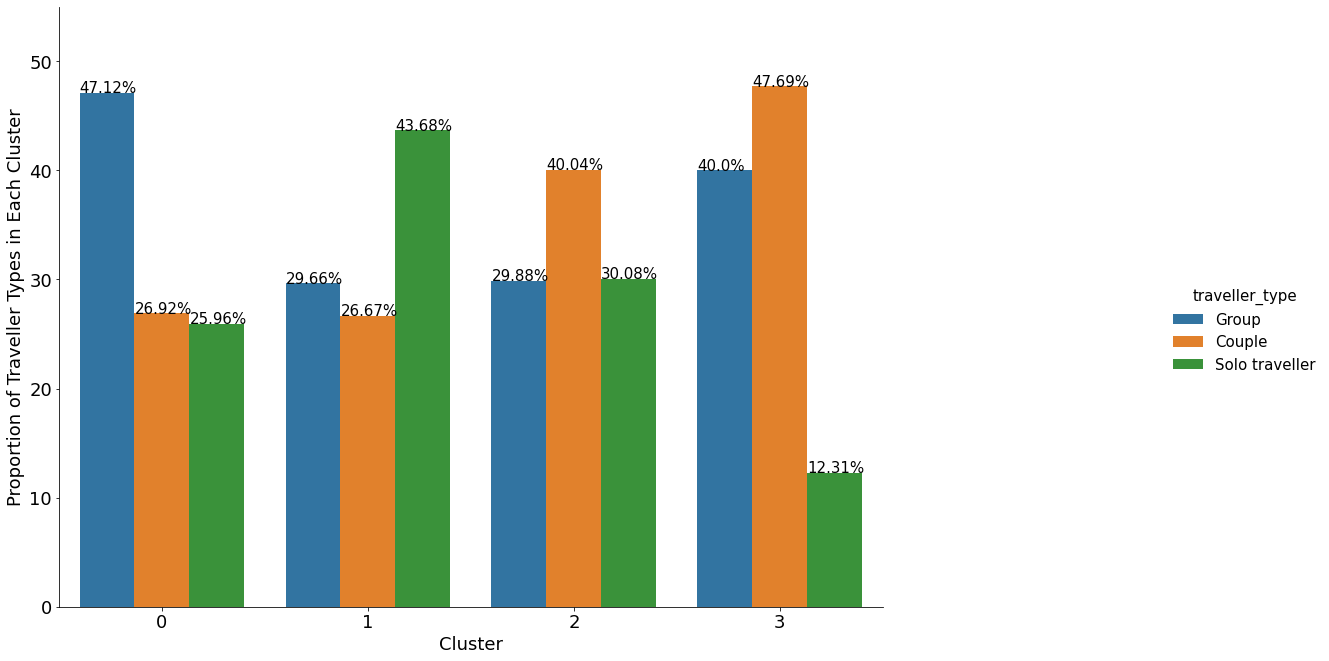

<Figure size 432x288 with 0 Axes>

In [ ]:
# 2D visualisation of proportion of traveller_type in each cluster

x,y = "Cluster", "traveller_type"
bargraph = df_sampled_4.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind = 'bar')
bargraph.ax.set_ylim(0,55)
bargraph.ax.tick_params(axis='both', which='major', labelsize=18)

for p in bargraph.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    bargraph.ax.text(txt_x,txt_y,txt)
    
# set plotting params    
plt.gcf().set_size_inches(20,10)

plt.xlabel('Cluster', fontsize=18)
plt.ylabel('Proportion of Traveller Types in Each Cluster', fontsize=18)

params = {'legend.fontsize': 20,
          'legend.handlelength': 5,
          'font.size': 20}
plot.rcParams.update(params)

plt.figure()

### 6.5. Niche Hypothesis on Clusters 
#### To prove hypothesis that each hotel tend to target a specific group of Cluster / traveller type
#### We find the proportion of Cluster in each hotel:

In [ ]:
df_final1 = df_final.join(df3)

df_to_grp = df_final1.drop(['review_text' , 'raw_review_text'] , axis = 1)

df_grped = df_to_grp.groupby(['Cluster' , 'hotel_name']).agg({'hotel_name': 'count'})
df_grped_pct = df_grped.groupby(level = 1).apply(lambda x:100*x/float(x.sum()))
df_grped_pct = df_grped_pct.rename(columns={'hotel_name':'proportion'})

df_grped_pct = df_grped_pct.reset_index()

hotel_names = df_grped_pct['hotel_name'][0:20]


pivot_df = df_grped_pct.pivot(index = 'hotel_name' , columns = 'Cluster' , values = 'proportion')
df_grped_pct = pivot_df.reset_index()


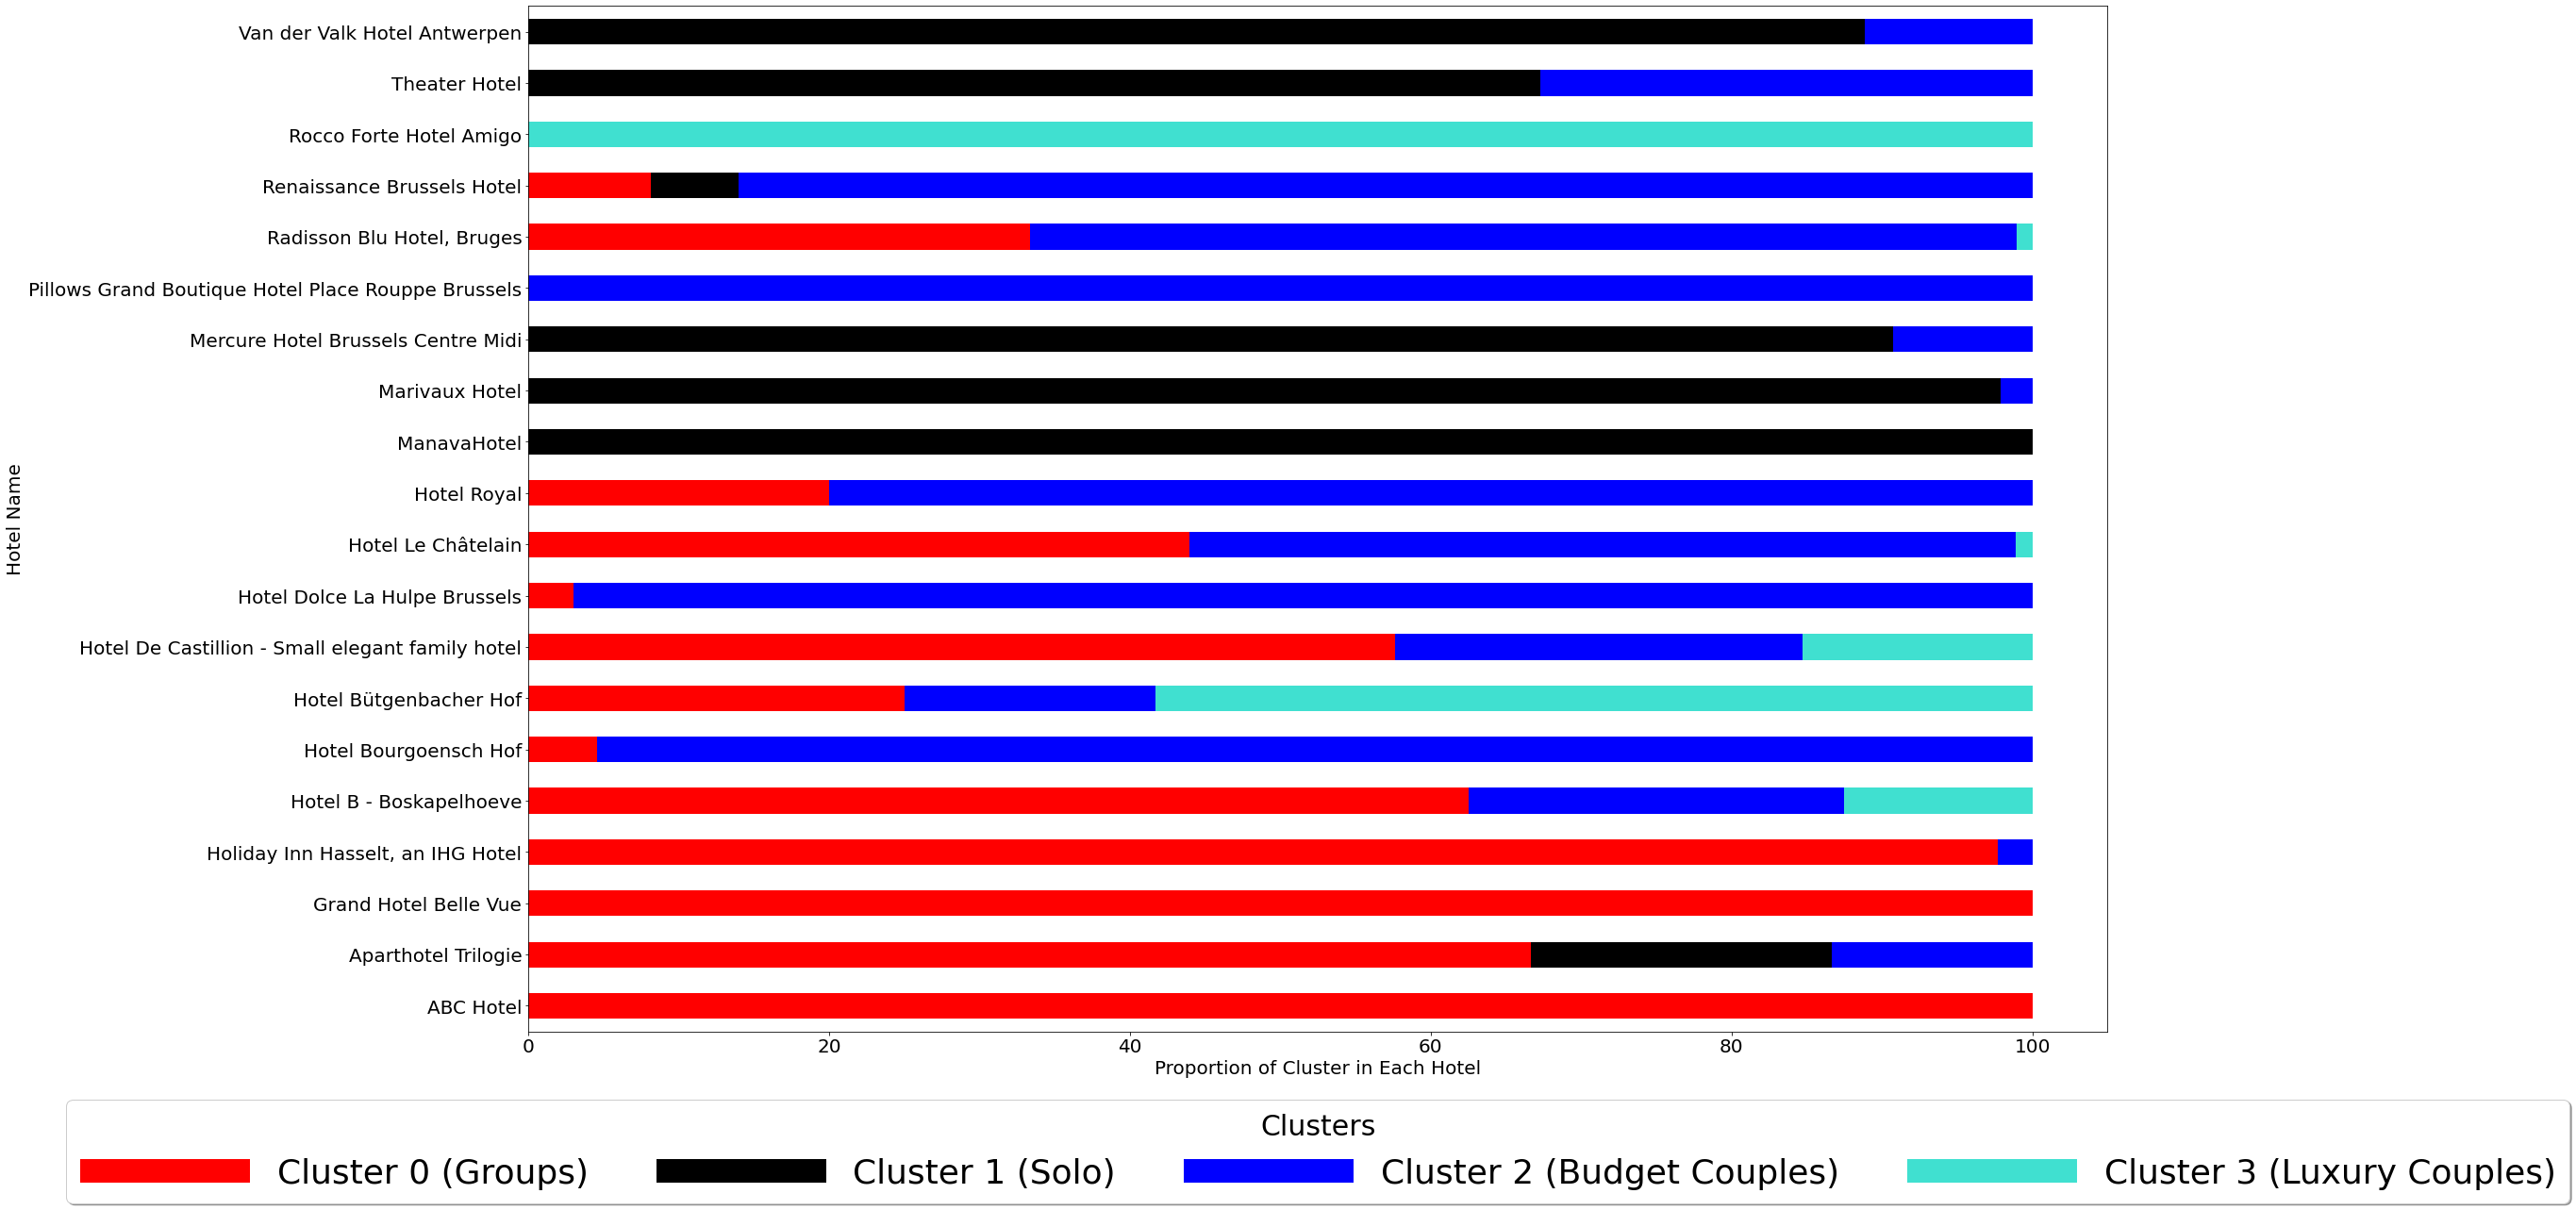

In [ ]:

df_grped_pct.plot(x = 'hotel_name', kind = 'barh', stacked = True, color = colours)


params = {'legend.fontsize': 25,
          'legend.handlelength': 5,
          'font.size': 30}

plot.rcParams.update(params)

plt.xlabel("Proportion of Cluster in Each Hotel")
plt.ylabel("Hotel Name")

legend_labels = ["Cluster 0 (Groups)", "Cluster 1 (Solo)", "Cluster 2 (Budget Couples)", "Cluster 3 (Luxury Couples)"]



plt.legend(legend_labels,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol = 4, title = 'Clusters', fontsize = 'large')

plt.gcf().set_size_inches(30,20)

#### From the figure above, we see that most hotels tend to focus on a certain cluster (i.e. one colour dominating the entire bar)
#### There are no hotels that targets all 4 clusters (i.e. no bars with all 4 colours)

# 7. 3D Visualisation of Cluster

In [ ]:
# Label encoding Occupation/Sex for visualization

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_sampled['traveller_type_encoded'] = le.fit_transform(df_sampled['traveller_type'])
df_sampled['traveller_type_encoded'].astype(int)

# 0: Couple
# 1: Group
# 2: solo traveller

df_sampled.head()

,rating,quarter,traveller_type,price_per_night,traveller_type_encoded
3,9.000,1,Solo traveller,119,2
340,10.000,1,Solo traveller,145,2
1615,10.000,2,Solo traveller,190,2
1222,1.000,1,Solo traveller,158,2
102,8.300,2,Solo traveller,99,2


In [ ]:
matplotlib.rc_file_defaults()

FixedFormatter should only be used together with FixedLocator


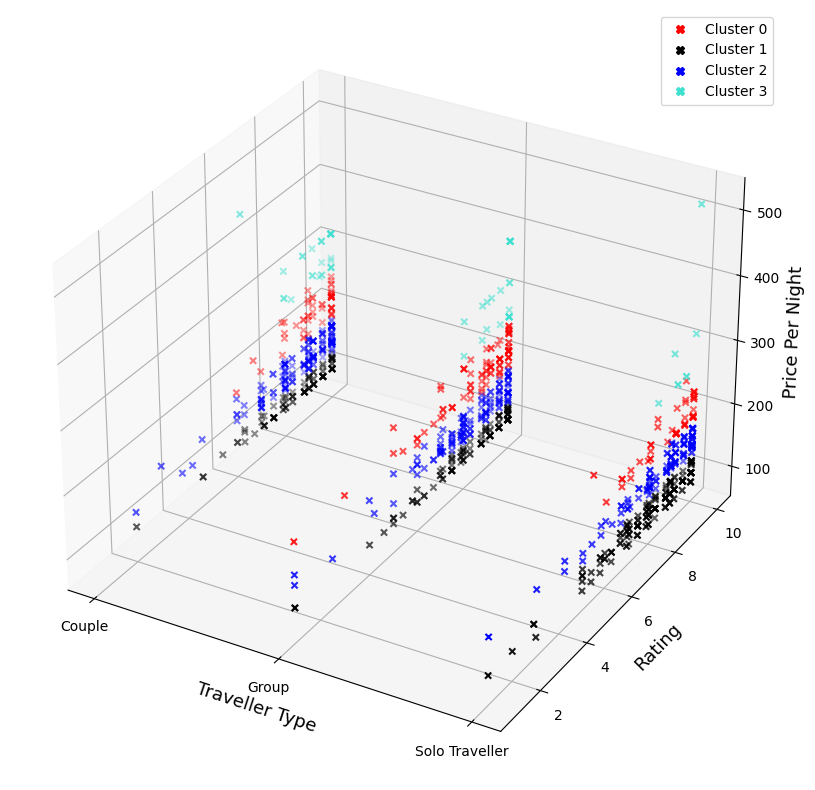

In [ ]:
#Visualizing the  3d graph


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sampled['traveller_type_encoded'],df_sampled['rating'], df_sampled['price_per_night'], c=Cluster_color, marker='x')


labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Couple'
labels[1] = 'Group'
labels[2] = 'Solo Traveller'
ax.set_xticklabels(labels)

ax.set_xticks([0,1,2])
ax.set_xlabel('Traveller Type', fontsize= 13)
ax.set_ylabel('Rating', fontsize= 13)
ax.set_zlabel('Price Per Night', fontsize= 13)

# set plotting params    
plt.gcf().set_size_inches(20,10)

scatter_proxy = []
for i in range(0,4):
    marker = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colours[i], marker = 'X')
    scatter_proxy.append(marker)
    
ax.legend(scatter_proxy, ['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3'], numpoints = 1)


params = {'legend.fontsize': 5,
          'legend.handlelength': 5}
plot.rcParams.update(params)

plt.show()



# 